In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from skimage import io
from scipy.stats import describe
from skimage.exposure import rescale_intensity, histogram, adjust_gamma
from flowdec import data as fd_data
import pims
# import pims
from skimage import io
from flowdec import restoration as fd_restoration
from flowdec import data as fd_data
from flowdec import psf as fd_psf
import dask
import dask.array as da
import tifffile as tf
from nd2reader import ND2Reader
from pims import ND2_Reader as nd2_two
import matplotlib.pyplot as plt


In [2]:
# channels = ['miRFP670', 'mRuby3','FITC']


In [3]:
# fname = 'igfp1_caruby5_continue001trigger003.nd2'
fname = '/media/extrahome/jmamede/Data/igfp1_caruby5_VOG004.nd2'
# fname = '/tmp/test.ome.tiff'

frames =  ND2Reader(fname)
# fames2 = nd2_two(fname)
# frames = pims.bioformats.BioformatsReader(fname)
# frames.reader=0
frames.iter_axes = 't'  # 't' is the default already
frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default

print(frames[1][0,:,:].max())

/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (45337.0 ms) doesn't match the set interval (45000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


896.0


dict_keys(['height', 'width', 'date', 'fields_of_view', 'frames', 'z_levels', 'z_coordinates', 'total_images_per_channel', 'channels', 'pixel_microns', 'num_frames', 'experiment', 'events'])


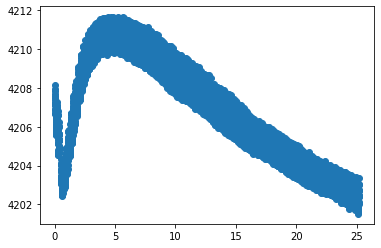

In [30]:
frames.sizes
#['z']
#frames.bundle_axes = 'czyx'  # when 'z' is available, this will be default
#frames.iter_axes = 'c' 
#frames.default_coords['c'] = 1  # 0 is the default setting
#for frame in frames[:3]:
    # do something with 3D frames in channel 1
channels =  frames.metadata['channels']
metadata = frames.metadata
# print(frames.metadata['events'])
# print(fames2.metadata.keys())
# print(fames2.metadata.flush())
# print(frames.parser._metadata.image_text_info)
# frames.get_timesteps()/60.
# frames

#the time steps only count once per channel, I don't know if it's because I have triggered acquisition.
times = frames.get_timesteps()
# print(len(times))
# plt.plot(range(len(times)),times/60/60/60)
print(metadata.keys())
# print(frames[0])
# print(frames.metadata['z_coordinates'])
plt.scatter(times/60/60/60,frames.metadata['z_coordinates'])

In [113]:
frames.parser._raw_metadata.image_text_info
# print(frames.parser._raw_metadata.acquisition_times)
# frames.parser._raw_metadata.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'ppNextLevelEx'][b''][b'uLoopPars'][b'dZStep']
# frames.parser._raw_metadata.image_text_info[b'SLxImageTextInfo'][b'TextInfoItem_5']

{b'SLxImageTextInfo': {b'TextInfoItem_0': b'',
  b'TextInfoItem_1': b'',
  b'TextInfoItem_2': b'',
  b'TextInfoItem_3': b'',
  b'TextInfoItem_4': b'',
  b'TextInfoItem_5': b'Metadata:\r\nDimensions: T(120) x XY(10) x Z(5) x \xce\xbb(1)\r\nCamera Name: pco.edge, SN:18500088\r\nNumerical Aperture: 1.4\r\nRefractive Index: 1.515\r\nNumber of Picture Planes: 2\r\nPlane #1:\r\n Name: 470 nm\r\n Component Count: 1\r\n Modality: Widefield Fluorescence\r\n Camera Settings:   \r\n  Camera Type: pco.edge\r\n  Exposure: 70 ms\r\n  Readout Mode: Rolling shutter at 16-bit\r\n  Readout Rate: 72 MHz\r\n  Noise Filter: Off\r\n  Temperature: -19.0\xc2\xb0C\r\n  MultiExcitation: On\r\n Microscope Settings:   NIDAQ, FilterChanger(FilterWheel): 5 (FITC (Em))\r\n  Spectra/AuraII, Shutter(Spectra): Open\r\n  Spectra/AuraII, MultiLaser(Spectra):\r\n     Line:1; ExW:395; Power:  0.0; Off\r\n     Line:2; ExW:440; Power:  0.0; Off\r\n     Line:3; ExW:470; Power:  8.0; On\r\n     Line:4; ExW:508; Power:  0.0; Of

In [96]:
frames.read_met_label_map

AttributeError: 'dict' object has no attribute '_label_map'

In [104]:
def Nd2meta2OMEXML(reader):
    from apeer_ometiff_library import omexmlClass
    
    def writeplanes(pixel, SizeT=1, SizeZ=1, SizeC=1, order='TZCYX', verbose=False):

        if order == 'TZCYX':

            pixel.DimensionOrder = omexmlClass.DO_XYCZT
            counter = 0
            for t in range(SizeT):
                for z in range(SizeZ):
                    for c in range(SizeC):

                        if verbose:
                            print('Write PlaneTable: ', t, z, c),
                            sys.stdout.flush()

                        pixel.Plane(counter).TheT = t
                        pixel.Plane(counter).TheZ = z
                        pixel.Plane(counter).TheC = c
                        #check basically because of triggered acquisition the arrays don't have the size of "channel"
                        pixel.Plane(counter).DeltaT = reader.get_timesteps()[counter//SizeC]
                        pixel.Plane(counter).PositionZ = nd2meta['z_coordinates'][counter//SizeC]
#                         pixel.Plane(counter).ExposureTime = 
#                         pixel.Plane(counter).PositionX =
#                         pixel.Plane(counter).PositionY = 
#                         pixel.Plane(counter).
                        counter = counter + 1
                        
    
        return pixel
    
    #make a metadata var
    nd2meta = reader.metadata
    
#     SizeT = nd2meta['frames'][-1]+1
#     SizeZ = nd2meta['z_levels'][-1]+1
#     SizeC = len(nd2meta['channels'])
#     SizeX = nd2meta['width']
#     SizeY = nd2meta['height']
#     print(SizeZ, SizeC, SizeX, SizeY)/
#     Series = nd2meta['fields_of_view'][-1]+1
    scalex = nd2meta['pixel_microns']
    scaley = scalex
#     scalez = round(nd2meta['z_coordinates'][1]-nd2meta['z_coordinates'][0],3)
    scalez = frames.parser._raw_metadata.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'ppNextLevelEx'][b''][b'uLoopPars'][b'dZStep']
    pixeltype = 'uint16'
    dimorder = 'TZCYX'
# print(a)
    omexml = omexmlClass.OMEXML()
#     omexml.image_count = 1
#     omexml.image_count = reader.sizes['v']
    omexml.image(0).Name = 'add a solution here'
#     for i in range(frames.sizes['t']):
    p = omexml.image(0).Pixels
    p.SizeX = frames.sizes['x']
    p.SizeY = frames.sizes['y']
    p.SizeC = frames.sizes['c']
    p.SizeT = frames.sizes['t']
    p.SizeZ = frames.sizes['z']
#     p.SizeZ = 1
    p.PhysicalSizeX = np.float(scalex)
    p.PhysicalSizeY = np.float(scaley)
    p.PhysicalSizeZ = np.float(scalez)
    p.PixelType = pixeltype
    p.channel_count = frames.sizes['c']
    p.plane_count = p.SizeZ * p.SizeT * p.SizeC #* SizeV
#     p.plane_count = p.SizeT * p.SizeC

    #for each V? Or separate files so not needed
    p = writeplanes(p, SizeT=p.SizeT, SizeZ=p.SizeZ, SizeC=p.SizeC, order=dimorder)
    for c in range(p.SizeC):
        if pixeltype == 'unit8':
            p.Channel(c).SamplesPerPixel = 1
        if pixeltype == 'unit16':
            p.Channel(c).SamplesPerPixel = 2
        
    omexml.structured_annotations.add_original_metadata(omexmlClass.OM_SAMPLES_PER_PIXEL, str(p.SizeC))
    
    return omexml.to_xml()
    

In [106]:
# nd2meta = metadata
xml = Nd2meta2OMEXML(frames)
# print(beta)
# frames
xml.image().Pixels.PhysicalSizeX
# xml = xml.to_xml()

# print(xml)

0.108333333333333

In [10]:
psf =[]
#psf = fd_psf.GibsonLanni.load('/tmp/psf.json')

# args = [na=1.4, wavelength= 0.594 , size_z=  11, size_x=  2048, size_y=  2044,
#         m :60,ns =  1.333, ni =  1.5156, tg =  170,         
#         res_lateral =  0.108333333333333, res_axial =  0.3, pZ = 1]

# args = [{"na": 1.4, "wavelength": '0.594' ,
#          "size_z": 11, "size_x": 2048, "size_y": 2044,
#          "m" :60,"ns" : 1.333, "ni" : 1.5156, "tg" : 170,
#          "res_lateral" : 0.108333333333333, "res_axial" : 0.3,
#          "pZ" :1}]

#na = meta['NA']
na = 1.4
#ra = meta['refractive_index1']
ra = 1.5156
z = frames.sizes['z']
x = frames.sizes['x']
y = frames.sizes['y']
# x = 1022
# y = 1022
res_z = 0.3
res_xy =  0.108333

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.670 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psf647 = psf.generate()    
    
psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.620 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfruby = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.535 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfgfp = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.420 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfdapi = psf.generate()  

# from pims import Frame
# Frame(psfdapi)
print(psf647.shape)
print(frames[0][:,512:1536,512:1536].shape)


#ms = []
def observer(img, i, *args):
    #mgs.append(img.max(axis=0))
    if i % 5 == 0:
        print('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max()))   
#config = tf.ConfigProto(device_count={'GPU': 1})
#algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=acq.data.ndim, pad_min=[1, 1, 1], session_config=config).initialize()
algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=psfgfp.ndim
                                                #, pad_mode='none'
                                                #, pad_mode='none'
                                                #, pad_min=[1,1,1]
                                                #,pad_min=np.ones(psfdapi.ndim)
                                                ,observer_fn=observer
                                                #,real_domain_fft=True
                                                #,device='/cpu:0'
                                                
                                               ).initialize()

(5, 2044, 2048)
(5, 1024, 1024)


In [11]:
def deconv(chunk):
    # note that algo and cropped_kernel are from global scope ... ugly
    print("chunk shape", chunk.shape)
    tmp = algo.initialize().run(fd_data.Acquisition(data=chunk, kernel=psf)
#                                 , session_config=tflow.compat.v1.ConfigProto(
#                                 device_count={'GPU': 1}        
#                                 , GPUOptions={'allow_growth' : 4}
#                                         )
                                ,niter=15
                               )
    return tmp.data

10
120
165.96041711258562
124.08112726080907
165.96041711258562
124.08112726080907


165.96041711258562
124.08112726080907
165.96041711258562
124.08112726080907


In [13]:
# chunk_size=(frames.sizes['z'],1022,1022)
chunk_size=(frames.sizes['z'],frames.sizes['y'],frames.sizes['x'])
# frames.iter_axes = 'v'
# for frame in frames:
for visit in range(frames.sizes['v']):
    #%timeit
    frames.default_coords['v'] = visit
    with tf.TiffWriter('/media/extrahome/jmamede/Data/'
#                        +fname[:-4]
                       +'v'+str(visit)+'.ome.tiff'
                , bigtiff=True
               #, imagej=True
                , imagej=False
#                 , metadata=None
                      ) as tif:
        with tf.TiffWriter('/media/extrahome/jmamede/Data/'
#                        +fname[:-4]
                       +'v'+str(visit)+'PRJ.ome.tiff'
                , bigtiff=True
               #, imagej=True
                , imagej=False
#                 , metadata=None
                      ) as tifprj:
            first = True
            print('Visit:',visit)
            for time in range(frames.sizes['t']):
                print('Time:',time)

    #             for ch in channels:
                res = np.zeros(
                    (frames.sizes['z'],frames.sizes['c'],frames.sizes['y'],frames.sizes['x'])
                    , dtype=np.float32)
                for i in range(frames.sizes['c']):
                    frames.default_coords['c'] = i
                    print('Channel:',metadata['channels'][i])
                    ch = metadata['channels'][i]
                    if ch == '405 nm':
                        psf = psfdapi
                    elif ch == '555 nm':
                        psf = psfruby
                    elif ch == '470 nm':
                        psf = psfgfp

                    arr = da.from_array(frames[time]
    #                                     [:,0:2044,0:2044]
    #                                     [:,:,:]              
                                        , chunks=chunk_size)
                    print(frames[time].shape,i, frames[i].max())

    #make mem efficient by creating and empty array with the right shape with all channels and then add it as it goes.
                    res[:,i,:,:] = arr.map_overlap(
    #                 res = arr.map_overlap(
    #                     deconv,depth=(0,6,6),
                        deconv,depth=(0,0,0),
                        boundary='reflect',
                        dtype='float32').compute(num_workers=1)
    #                     res[i,:,:,:] = arr.map_blocks(
    #                         deconv,dtype='float32').compute(num_workers=1)
    #             img5d = np.swapaxes(img5d,0,1)
                if first:
                    tif.save(res.astype(np.uint16)
                    , description = xml
                    , photometric='minisblack'
                    #, datetime= True
                    , metadata= None
                    , contiguous=False
                        )
                    first = False
                else:
                    tif.save(res.astype(np.uint16)
                        , description = xml
                    , photometric='minisblack'
                    , metadata= None
                    , contiguous=False
                        )

        tif.close()
        tifprj.close()

Visit: 0
Time: 0
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2153.841)
Observing iteration = 10 (dtype = float32, max = 2896.792)
Observing iteration = 15 (dtype = float32, max = 3311.111)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 6051.364)
Observing iteration = 10 (dtype = float32, max = 8176.499)
Observing iteration = 15 (dtype = float32, max = 9382.559)
Time: 1
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1971.523)
Observing iteration = 10 (dtype = float32, max = 2374.144)
Observing iteration = 15 (dtype = float32, max = 2639.184)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 6169.814)
Observing iteration = 10 

chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2456.358)
Observing iteration = 10 (dtype = float32, max = 3570.317)
Observing iteration = 15 (dtype = float32, max = 4304.189)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 5532.163)
Observing iteration = 10 (dtype = float32, max = 7085.241)
Observing iteration = 15 (dtype = float32, max = 7624.859)
Time: 16
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2126.413)
Observing iteration = 10 (dtype = float32, max = 3010.604)
Observing iteration = 15 (dtype = float32, max = 3599.823)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 5484.096)
Observing iteration = 10 (dtype = float32, max = 7175.282)
Observing iteration = 15 (dtype = float32, ma

Observing iteration = 10 (dtype = float32, max = 2749.860)
Observing iteration = 15 (dtype = float32, max = 2960.452)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4981.725)
Observing iteration = 10 (dtype = float32, max = 6476.711)
Observing iteration = 15 (dtype = float32, max = 7024.241)
Time: 31
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2511.441)
Observing iteration = 10 (dtype = float32, max = 3645.642)
Observing iteration = 15 (dtype = float32, max = 4356.033)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4671.005)
Observing iteration = 10 (dtype = float32, max = 6296.868)
Observing iteration = 15 (dtype = float32, max = 7405.607)
Time: 32
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3898.744)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3951.834)
Observing iteration = 10 (dtype = float32, max = 4965.535)
Observing iteration = 15 (dtype = float32, max = 5395.413)
Time: 46
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2459.694)
Observing iteration = 10 (dtype = float32, max = 3052.374)
Observing iteration = 15 (dtype = float32, max = 3387.078)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4446.829)
Observing iteration = 10 (dtype = float32, max = 5753.478)
Observing iteration = 15 (dtype = float32, max = 6221.527)
Time: 47
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3540.335)
Observing iteration = 10 (dtype = float32, max = 4373.373)
Observing iteration = 15 (dtype = float32, max = 4683.208)
Time: 61
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2049.390)
Observing iteration = 10 (dtype = float32, max = 2697.009)
Observing iteration = 15 (dtype = float32, max = 3034.895)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3627.324)
Observing iteration = 10 (dtype = float32, max = 4665.718)
Observing iteration = 15 (dtype = float32, max = 5042.104)
Time: 62
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2209.984)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 3085.053)
Observing iteration = 10 (dtype = float32, max = 3941.904)
Observing iteration = 15 (dtype = float32, max = 4245.177)
Time: 76
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1966.444)
Observing iteration = 10 (dtype = float32, max = 2441.454)
Observing iteration = 15 (dtype = float32, max = 2787.430)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3135.209)
Observing iteration = 10 (dtype = float32, max = 3850.719)
Observing iteration = 15 (dtype = float32, max = 4070.907)
Time: 77
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2059.787)
Observing iteration = 10 (dtype = float32, max = 2506.900)
Observing iteration = 15 (dtype = float32, max = 2693.920)
Chann

Observing iteration = 10 (dtype = float32, max = 3653.076)
Observing iteration = 15 (dtype = float32, max = 3916.341)
Time: 91
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1903.998)
Observing iteration = 10 (dtype = float32, max = 2403.309)
Observing iteration = 15 (dtype = float32, max = 2749.069)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2628.731)
Observing iteration = 10 (dtype = float32, max = 3359.681)
Observing iteration = 15 (dtype = float32, max = 3612.477)
Time: 92
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2018.504)
Observing iteration = 10 (dtype = float32, max = 2581.416)
Observing iteration = 15 (dtype = float32, max = 3002.624)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3163.687)
Time: 106
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1975.275)
Observing iteration = 10 (dtype = float32, max = 2441.083)
Observing iteration = 15 (dtype = float32, max = 2580.142)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2361.326)
Observing iteration = 10 (dtype = float32, max = 3007.084)
Observing iteration = 15 (dtype = float32, max = 3215.426)
Time: 107
Channel: 470 nm
(5, 2044, 2048) 0 1743.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1779.653)
Observing iteration = 10 (dtype = float32, max = 2054.325)
Observing iteration = 15 (dtype = float32, max = 2132.082)
Channel: 555 nm
(5, 2044, 2048) 1 3819.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2294.214)
Observing iteration = 10 (dtype = float32, max = 3002.347)
Observing iteration = 15 (dtype = float32, max = 3267.045)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3004.229)
Observing iteration = 10 (dtype = float32, max = 3867.014)
Observing iteration = 15 (dtype = float32, max = 4246.589)
Time: 2
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2505.930)
Observing iteration = 10 (dtype = float32, max = 3064.881)
Observing iteration = 15 (dtype = float32, max = 3181.006)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3004.425)
Observing iteration = 10 (dtype = float32, max = 3758.964)

Observing iteration = 5 (dtype = float32, max = 2929.988)
Observing iteration = 10 (dtype = float32, max = 3900.485)
Observing iteration = 15 (dtype = float32, max = 4313.124)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2538.559)
Observing iteration = 10 (dtype = float32, max = 3182.062)
Observing iteration = 15 (dtype = float32, max = 3380.544)
Time: 17
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3136.790)
Observing iteration = 10 (dtype = float32, max = 3979.860)
Observing iteration = 15 (dtype = float32, max = 4187.896)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2641.329)
Observing iteration = 10 (dtype = float32, max = 3382.454)
Observing iteration = 15 (dtype = float32, max = 3537.850)
Time: 18
Chann

Observing iteration = 10 (dtype = float32, max = 3187.833)
Observing iteration = 15 (dtype = float32, max = 3730.049)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1687.807)
Observing iteration = 10 (dtype = float32, max = 2087.684)
Observing iteration = 15 (dtype = float32, max = 2433.744)
Time: 32
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2588.773)
Observing iteration = 10 (dtype = float32, max = 3288.361)
Observing iteration = 15 (dtype = float32, max = 3803.322)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1951.184)
Observing iteration = 10 (dtype = float32, max = 2507.393)
Observing iteration = 15 (dtype = float32, max = 2700.974)
Time: 33
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 4942.943)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2041.513)
Observing iteration = 10 (dtype = float32, max = 2761.552)
Observing iteration = 15 (dtype = float32, max = 3078.802)
Time: 47
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3105.955)
Observing iteration = 10 (dtype = float32, max = 4177.702)
Observing iteration = 15 (dtype = float32, max = 4625.561)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1869.233)
Observing iteration = 10 (dtype = float32, max = 2496.179)
Observing iteration = 15 (dtype = float32, max = 2760.922)
Time: 48
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1524.086)
Observing iteration = 10 (dtype = float32, max = 1960.000)
Observing iteration = 15 (dtype = float32, max = 2109.952)
Time: 62
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2965.995)
Observing iteration = 10 (dtype = float32, max = 3653.857)
Observing iteration = 15 (dtype = float32, max = 3744.291)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1430.350)
Observing iteration = 10 (dtype = float32, max = 1844.663)
Observing iteration = 15 (dtype = float32, max = 1998.803)
Time: 63
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2976.317)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1393.178)
Observing iteration = 10 (dtype = float32, max = 1758.264)
Observing iteration = 15 (dtype = float32, max = 1890.996)
Time: 77
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2734.008)
Observing iteration = 10 (dtype = float32, max = 3518.673)
Observing iteration = 15 (dtype = float32, max = 3789.683)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1460.290)
Observing iteration = 10 (dtype = float32, max = 1843.343)
Observing iteration = 15 (dtype = float32, max = 1927.976)
Time: 78
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2425.858)
Observing iteration = 10 (dtype = float32, max = 2938.658)
Observing iteration = 15 (dtype = float32, max = 3109.299)
Chann

Observing iteration = 10 (dtype = float32, max = 1354.238)
Observing iteration = 15 (dtype = float32, max = 1459.590)
Time: 92
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2232.808)
Observing iteration = 10 (dtype = float32, max = 2782.026)
Observing iteration = 15 (dtype = float32, max = 3208.211)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1131.251)
Observing iteration = 10 (dtype = float32, max = 1466.010)
Observing iteration = 15 (dtype = float32, max = 1588.406)
Time: 93
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1933.448)
Observing iteration = 10 (dtype = float32, max = 2300.145)
Observing iteration = 15 (dtype = float32, max = 2574.781)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 1584.046)
Time: 107
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2448.308)
Observing iteration = 10 (dtype = float32, max = 2942.393)
Observing iteration = 15 (dtype = float32, max = 3178.661)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1029.769)
Observing iteration = 10 (dtype = float32, max = 1331.265)
Observing iteration = 15 (dtype = float32, max = 1518.135)
Time: 108
Channel: 470 nm
(5, 2044, 2048) 0 1462.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2158.939)
Observing iteration = 10 (dtype = float32, max = 2611.713)
Observing iteration = 15 (dtype = float32, max = 2754.851)
Channel: 555 nm
(5, 2044, 2048) 1 1885.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3245.092)
Observing iteration = 10 (dtype = float32, max = 4207.479)
Observing iteration = 15 (dtype = float32, max = 4551.401)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 8676.458)
Observing iteration = 10 (dtype = float32, max = 10562.150)
Observing iteration = 15 (dtype = float32, max = 10704.746)
Time: 3
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3245.380)
Observing iteration = 10 (dtype = float32, max = 4010.890)
Observing iteration = 15 (dtype = float32, max = 4297.806)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 9559.024)
Observing iteration = 10 (dtype = float32, max = 11971.5

chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2139.019)
Observing iteration = 10 (dtype = float32, max = 2683.063)
Observing iteration = 15 (dtype = float32, max = 2979.556)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 7605.232)
Observing iteration = 10 (dtype = float32, max = 9222.840)
Observing iteration = 15 (dtype = float32, max = 9300.592)
Time: 18
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2373.313)
Observing iteration = 10 (dtype = float32, max = 2874.878)
Observing iteration = 15 (dtype = float32, max = 3084.769)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 7795.156)
Observing iteration = 10 (dtype = float32, max = 9459.485)
Observing iteration = 15 (dtype = float32, ma

Observing iteration = 10 (dtype = float32, max = 2584.771)
Observing iteration = 15 (dtype = float32, max = 2741.515)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 6053.755)
Observing iteration = 10 (dtype = float32, max = 7535.912)
Observing iteration = 15 (dtype = float32, max = 8080.993)
Time: 33
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2296.723)
Observing iteration = 10 (dtype = float32, max = 2677.871)
Observing iteration = 15 (dtype = float32, max = 2781.353)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 6228.014)
Observing iteration = 10 (dtype = float32, max = 7823.832)
Observing iteration = 15 (dtype = float32, max = 8400.080)
Time: 34
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 2507.326)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 5495.490)
Observing iteration = 10 (dtype = float32, max = 6755.082)
Observing iteration = 15 (dtype = float32, max = 7169.964)
Time: 48
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2202.526)
Observing iteration = 10 (dtype = float32, max = 2549.410)
Observing iteration = 15 (dtype = float32, max = 2664.803)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 5798.855)
Observing iteration = 10 (dtype = float32, max = 7185.161)
Observing iteration = 15 (dtype = float32, max = 7695.827)
Time: 49
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4589.615)
Observing iteration = 10 (dtype = float32, max = 5462.395)
Observing iteration = 15 (dtype = float32, max = 5791.112)
Time: 63
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2117.547)
Observing iteration = 10 (dtype = float32, max = 2449.964)
Observing iteration = 15 (dtype = float32, max = 2831.111)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4609.004)
Observing iteration = 10 (dtype = float32, max = 5630.038)
Observing iteration = 15 (dtype = float32, max = 5920.623)
Time: 64
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2192.640)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 5147.995)
Observing iteration = 10 (dtype = float32, max = 6427.182)
Observing iteration = 15 (dtype = float32, max = 6694.524)
Time: 78
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2230.536)
Observing iteration = 10 (dtype = float32, max = 2863.269)
Observing iteration = 15 (dtype = float32, max = 3019.095)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4783.505)
Observing iteration = 10 (dtype = float32, max = 5820.587)
Observing iteration = 15 (dtype = float32, max = 5908.695)
Time: 79
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2076.559)
Observing iteration = 10 (dtype = float32, max = 2414.628)
Observing iteration = 15 (dtype = float32, max = 2518.663)
Chann

Observing iteration = 10 (dtype = float32, max = 5168.785)
Observing iteration = 15 (dtype = float32, max = 5254.121)
Time: 93
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2220.739)
Observing iteration = 10 (dtype = float32, max = 2626.691)
Observing iteration = 15 (dtype = float32, max = 2764.382)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3671.158)
Observing iteration = 10 (dtype = float32, max = 4254.892)
Observing iteration = 15 (dtype = float32, max = 4440.114)
Time: 94
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2171.525)
Observing iteration = 10 (dtype = float32, max = 2534.844)
Observing iteration = 15 (dtype = float32, max = 2655.615)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 4103.510)
Time: 108
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2209.552)
Observing iteration = 10 (dtype = float32, max = 2659.130)
Observing iteration = 15 (dtype = float32, max = 2843.930)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3811.673)
Observing iteration = 10 (dtype = float32, max = 4639.621)
Observing iteration = 15 (dtype = float32, max = 4715.182)
Time: 109
Channel: 470 nm
(5, 2044, 2048) 0 1411.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2074.538)
Observing iteration = 10 (dtype = float32, max = 2436.408)
Observing iteration = 15 (dtype = float32, max = 2558.817)
Channel: 555 nm
(5, 2044, 2048) 1 4707.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2508.121)
Observing iteration = 10 (dtype = float32, max = 3068.359)
Observing iteration = 15 (dtype = float32, max = 3293.627)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3268.576)
Observing iteration = 10 (dtype = float32, max = 4069.184)
Observing iteration = 15 (dtype = float32, max = 4333.994)
Time: 4
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2962.338)
Observing iteration = 10 (dtype = float32, max = 3771.595)
Observing iteration = 15 (dtype = float32, max = 3930.746)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3962.979)
Observing iteration = 10 (dtype = float32, max = 4940.735)

Observing iteration = 5 (dtype = float32, max = 2995.826)
Observing iteration = 10 (dtype = float32, max = 3833.998)
Observing iteration = 15 (dtype = float32, max = 4186.458)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2528.132)
Observing iteration = 10 (dtype = float32, max = 3321.019)
Observing iteration = 15 (dtype = float32, max = 3782.779)
Time: 19
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2583.759)
Observing iteration = 10 (dtype = float32, max = 3114.492)
Observing iteration = 15 (dtype = float32, max = 3538.389)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2747.050)
Observing iteration = 10 (dtype = float32, max = 3363.610)
Observing iteration = 15 (dtype = float32, max = 3482.395)
Time: 20
Chann

Observing iteration = 10 (dtype = float32, max = 3298.591)
Observing iteration = 15 (dtype = float32, max = 3557.749)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2560.757)
Observing iteration = 10 (dtype = float32, max = 3561.030)
Observing iteration = 15 (dtype = float32, max = 4202.939)
Time: 34
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2767.772)
Observing iteration = 10 (dtype = float32, max = 3487.739)
Observing iteration = 15 (dtype = float32, max = 3844.282)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2776.726)
Observing iteration = 10 (dtype = float32, max = 3456.075)
Observing iteration = 15 (dtype = float32, max = 3585.277)
Time: 35
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3924.674)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2789.473)
Observing iteration = 10 (dtype = float32, max = 3658.532)
Observing iteration = 15 (dtype = float32, max = 4166.199)
Time: 49
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2754.041)
Observing iteration = 10 (dtype = float32, max = 3495.503)
Observing iteration = 15 (dtype = float32, max = 3768.813)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2337.829)
Observing iteration = 10 (dtype = float32, max = 3244.436)
Observing iteration = 15 (dtype = float32, max = 3797.307)
Time: 50
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2463.036)
Observing iteration = 10 (dtype = float32, max = 3166.455)
Observing iteration = 15 (dtype = float32, max = 3340.402)
Time: 64
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2290.285)
Observing iteration = 10 (dtype = float32, max = 2818.831)
Observing iteration = 15 (dtype = float32, max = 2942.712)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2117.842)
Observing iteration = 10 (dtype = float32, max = 2654.112)
Observing iteration = 15 (dtype = float32, max = 2874.652)
Time: 65
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2589.732)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1870.322)
Observing iteration = 10 (dtype = float32, max = 2338.542)
Observing iteration = 15 (dtype = float32, max = 2485.879)
Time: 79
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2368.477)
Observing iteration = 10 (dtype = float32, max = 2924.793)
Observing iteration = 15 (dtype = float32, max = 3177.109)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1896.938)
Observing iteration = 10 (dtype = float32, max = 2376.344)
Observing iteration = 15 (dtype = float32, max = 2472.993)
Time: 80
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1950.755)
Observing iteration = 10 (dtype = float32, max = 2307.475)
Observing iteration = 15 (dtype = float32, max = 2319.036)
Chann

Observing iteration = 10 (dtype = float32, max = 2086.460)
Observing iteration = 15 (dtype = float32, max = 2289.587)
Time: 94
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1699.285)
Observing iteration = 10 (dtype = float32, max = 2097.582)
Observing iteration = 15 (dtype = float32, max = 2162.681)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1460.877)
Observing iteration = 10 (dtype = float32, max = 1830.170)
Observing iteration = 15 (dtype = float32, max = 1961.803)
Time: 95
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1727.313)
Observing iteration = 10 (dtype = float32, max = 2141.416)
Observing iteration = 15 (dtype = float32, max = 2266.634)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 2037.609)
Time: 109
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1662.158)
Observing iteration = 10 (dtype = float32, max = 2011.168)
Observing iteration = 15 (dtype = float32, max = 2142.235)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1257.122)
Observing iteration = 10 (dtype = float32, max = 1576.775)
Observing iteration = 15 (dtype = float32, max = 1718.752)
Time: 110
Channel: 470 nm
(5, 2044, 2048) 0 1381.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1505.771)
Observing iteration = 10 (dtype = float32, max = 1767.648)
Observing iteration = 15 (dtype = float32, max = 1855.056)
Channel: 555 nm
(5, 2044, 2048) 1 2384.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3198.014)
Observing iteration = 10 (dtype = float32, max = 3976.526)
Observing iteration = 15 (dtype = float32, max = 4203.522)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4445.727)
Observing iteration = 10 (dtype = float32, max = 5550.270)
Observing iteration = 15 (dtype = float32, max = 5714.178)
Time: 5
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3085.826)
Observing iteration = 10 (dtype = float32, max = 3769.934)
Observing iteration = 15 (dtype = float32, max = 4007.209)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3278.449)
Observing iteration = 10 (dtype = float32, max = 4004.917)

Observing iteration = 5 (dtype = float32, max = 2769.948)
Observing iteration = 10 (dtype = float32, max = 3670.965)
Observing iteration = 15 (dtype = float32, max = 4246.047)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3320.554)
Observing iteration = 10 (dtype = float32, max = 4466.182)
Observing iteration = 15 (dtype = float32, max = 5141.546)
Time: 20
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3465.432)
Observing iteration = 10 (dtype = float32, max = 4435.045)
Observing iteration = 15 (dtype = float32, max = 4910.540)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3343.101)
Observing iteration = 10 (dtype = float32, max = 4390.581)
Observing iteration = 15 (dtype = float32, max = 4944.600)
Time: 21
Chann

Observing iteration = 10 (dtype = float32, max = 4436.616)
Observing iteration = 15 (dtype = float32, max = 5111.268)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3026.956)
Observing iteration = 10 (dtype = float32, max = 3756.828)
Observing iteration = 15 (dtype = float32, max = 4046.090)
Time: 35
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3409.635)
Observing iteration = 10 (dtype = float32, max = 4638.685)
Observing iteration = 15 (dtype = float32, max = 5475.519)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3130.590)
Observing iteration = 10 (dtype = float32, max = 3908.268)
Observing iteration = 15 (dtype = float32, max = 4419.936)
Time: 36
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 4841.985)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2902.704)
Observing iteration = 10 (dtype = float32, max = 3672.828)
Observing iteration = 15 (dtype = float32, max = 3917.237)
Time: 50
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3575.944)
Observing iteration = 10 (dtype = float32, max = 4557.687)
Observing iteration = 15 (dtype = float32, max = 4824.684)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2805.887)
Observing iteration = 10 (dtype = float32, max = 3400.352)
Observing iteration = 15 (dtype = float32, max = 3598.740)
Time: 51
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2535.119)
Observing iteration = 10 (dtype = float32, max = 3273.176)
Observing iteration = 15 (dtype = float32, max = 3613.485)
Time: 65
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3283.940)
Observing iteration = 10 (dtype = float32, max = 4201.600)
Observing iteration = 15 (dtype = float32, max = 4554.402)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2541.411)
Observing iteration = 10 (dtype = float32, max = 3191.179)
Observing iteration = 15 (dtype = float32, max = 3446.531)
Time: 66
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2619.024)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1967.023)
Observing iteration = 10 (dtype = float32, max = 2697.083)
Observing iteration = 15 (dtype = float32, max = 3162.734)
Time: 80
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2637.417)
Observing iteration = 10 (dtype = float32, max = 3257.016)
Observing iteration = 15 (dtype = float32, max = 3543.977)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2050.896)
Observing iteration = 10 (dtype = float32, max = 2585.946)
Observing iteration = 15 (dtype = float32, max = 2958.498)
Time: 81
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2793.474)
Observing iteration = 10 (dtype = float32, max = 3469.230)
Observing iteration = 15 (dtype = float32, max = 3704.511)
Chann

Observing iteration = 10 (dtype = float32, max = 2063.407)
Observing iteration = 15 (dtype = float32, max = 2218.774)
Time: 95
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2719.665)
Observing iteration = 10 (dtype = float32, max = 3397.739)
Observing iteration = 15 (dtype = float32, max = 3553.781)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1556.087)
Observing iteration = 10 (dtype = float32, max = 1959.089)
Observing iteration = 15 (dtype = float32, max = 2143.547)
Time: 96
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2550.312)
Observing iteration = 10 (dtype = float32, max = 3197.770)
Observing iteration = 15 (dtype = float32, max = 3548.533)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 2596.383)
Time: 110
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2427.320)
Observing iteration = 10 (dtype = float32, max = 3013.915)
Observing iteration = 15 (dtype = float32, max = 3444.185)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1367.463)
Observing iteration = 10 (dtype = float32, max = 1882.890)
Observing iteration = 15 (dtype = float32, max = 2210.287)
Time: 111
Channel: 470 nm
(5, 2044, 2048) 0 1636.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2205.698)
Observing iteration = 10 (dtype = float32, max = 2989.249)
Observing iteration = 15 (dtype = float32, max = 3506.058)
Channel: 555 nm
(5, 2044, 2048) 1 2514.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3342.076)
Observing iteration = 10 (dtype = float32, max = 4186.658)
Observing iteration = 15 (dtype = float32, max = 4332.205)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3384.037)
Observing iteration = 10 (dtype = float32, max = 4205.323)
Observing iteration = 15 (dtype = float32, max = 4375.553)
Time: 6
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3593.552)
Observing iteration = 10 (dtype = float32, max = 4463.193)
Observing iteration = 15 (dtype = float32, max = 4540.917)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3477.127)
Observing iteration = 10 (dtype = float32, max = 4595.601)

Observing iteration = 5 (dtype = float32, max = 3668.893)
Observing iteration = 10 (dtype = float32, max = 4900.614)
Observing iteration = 15 (dtype = float32, max = 5407.308)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3085.237)
Observing iteration = 10 (dtype = float32, max = 4034.345)
Observing iteration = 15 (dtype = float32, max = 4410.484)
Time: 21
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3159.827)
Observing iteration = 10 (dtype = float32, max = 3916.172)
Observing iteration = 15 (dtype = float32, max = 4164.007)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2901.590)
Observing iteration = 10 (dtype = float32, max = 3744.569)
Observing iteration = 15 (dtype = float32, max = 4380.877)
Time: 22
Chann

Observing iteration = 10 (dtype = float32, max = 4623.875)
Observing iteration = 15 (dtype = float32, max = 4967.181)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2715.075)
Observing iteration = 10 (dtype = float32, max = 3618.035)
Observing iteration = 15 (dtype = float32, max = 4225.845)
Time: 36
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3557.150)
Observing iteration = 10 (dtype = float32, max = 4425.108)
Observing iteration = 15 (dtype = float32, max = 4574.240)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2631.515)
Observing iteration = 10 (dtype = float32, max = 3281.595)
Observing iteration = 15 (dtype = float32, max = 3506.289)
Time: 37
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3847.071)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2426.766)
Observing iteration = 10 (dtype = float32, max = 3079.673)
Observing iteration = 15 (dtype = float32, max = 3500.682)
Time: 51
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3477.487)
Observing iteration = 10 (dtype = float32, max = 4652.026)
Observing iteration = 15 (dtype = float32, max = 5363.577)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2588.591)
Observing iteration = 10 (dtype = float32, max = 3312.059)
Observing iteration = 15 (dtype = float32, max = 3578.617)
Time: 52
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2227.367)
Observing iteration = 10 (dtype = float32, max = 2797.971)
Observing iteration = 15 (dtype = float32, max = 3170.096)
Time: 66
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3179.737)
Observing iteration = 10 (dtype = float32, max = 3909.562)
Observing iteration = 15 (dtype = float32, max = 4034.956)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2310.706)
Observing iteration = 10 (dtype = float32, max = 2872.530)
Observing iteration = 15 (dtype = float32, max = 2990.830)
Time: 67
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2965.828)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1932.875)
Observing iteration = 10 (dtype = float32, max = 2340.165)
Observing iteration = 15 (dtype = float32, max = 2486.273)
Time: 81
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2818.724)
Observing iteration = 10 (dtype = float32, max = 3616.609)
Observing iteration = 15 (dtype = float32, max = 3897.115)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2002.136)
Observing iteration = 10 (dtype = float32, max = 2434.399)
Observing iteration = 15 (dtype = float32, max = 2586.865)
Time: 82
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2557.624)
Observing iteration = 10 (dtype = float32, max = 3021.361)
Observing iteration = 15 (dtype = float32, max = 3159.609)
Chann

Observing iteration = 10 (dtype = float32, max = 2496.388)
Observing iteration = 15 (dtype = float32, max = 2609.716)
Time: 96
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2330.733)
Observing iteration = 10 (dtype = float32, max = 2704.641)
Observing iteration = 15 (dtype = float32, max = 2761.853)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1805.857)
Observing iteration = 10 (dtype = float32, max = 2212.611)
Observing iteration = 15 (dtype = float32, max = 2307.794)
Time: 97
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2689.812)
Observing iteration = 10 (dtype = float32, max = 3295.436)
Observing iteration = 15 (dtype = float32, max = 3354.028)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 2107.404)
Time: 111
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2462.787)
Observing iteration = 10 (dtype = float32, max = 2966.580)
Observing iteration = 15 (dtype = float32, max = 3110.213)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1677.996)
Observing iteration = 10 (dtype = float32, max = 2113.646)
Observing iteration = 15 (dtype = float32, max = 2448.461)
Time: 112
Channel: 470 nm
(5, 2044, 2048) 0 1490.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2428.827)
Observing iteration = 10 (dtype = float32, max = 2861.644)
Observing iteration = 15 (dtype = float32, max = 2972.086)
Channel: 555 nm
(5, 2044, 2048) 1 1992.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2166.520)
Observing iteration = 10 (dtype = float32, max = 2661.716)
Observing iteration = 15 (dtype = float32, max = 2799.115)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3353.330)
Observing iteration = 10 (dtype = float32, max = 4351.753)
Observing iteration = 15 (dtype = float32, max = 4615.375)
Time: 7
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2159.166)
Observing iteration = 10 (dtype = float32, max = 2635.278)
Observing iteration = 15 (dtype = float32, max = 2781.690)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3393.354)
Observing iteration = 10 (dtype = float32, max = 4121.765)

Observing iteration = 5 (dtype = float32, max = 2047.878)
Observing iteration = 10 (dtype = float32, max = 2803.400)
Observing iteration = 15 (dtype = float32, max = 3250.425)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2432.387)
Observing iteration = 10 (dtype = float32, max = 2967.624)
Observing iteration = 15 (dtype = float32, max = 3140.356)
Time: 22
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2076.281)
Observing iteration = 10 (dtype = float32, max = 2631.917)
Observing iteration = 15 (dtype = float32, max = 2849.579)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2456.773)
Observing iteration = 10 (dtype = float32, max = 3076.664)
Observing iteration = 15 (dtype = float32, max = 3271.114)
Time: 23
Chann

Observing iteration = 10 (dtype = float32, max = 2781.372)
Observing iteration = 15 (dtype = float32, max = 2908.604)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2512.135)
Observing iteration = 10 (dtype = float32, max = 2980.656)
Observing iteration = 15 (dtype = float32, max = 3114.427)
Time: 37
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2145.653)
Observing iteration = 10 (dtype = float32, max = 2700.574)
Observing iteration = 15 (dtype = float32, max = 3029.907)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2226.052)
Observing iteration = 10 (dtype = float32, max = 2658.614)
Observing iteration = 15 (dtype = float32, max = 2842.387)
Time: 38
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3027.746)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1799.294)
Observing iteration = 10 (dtype = float32, max = 2130.168)
Observing iteration = 15 (dtype = float32, max = 2234.792)
Time: 52
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2145.764)
Observing iteration = 10 (dtype = float32, max = 2701.263)
Observing iteration = 15 (dtype = float32, max = 2838.589)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1819.088)
Observing iteration = 10 (dtype = float32, max = 2147.395)
Observing iteration = 15 (dtype = float32, max = 2317.812)
Time: 53
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1673.423)
Observing iteration = 10 (dtype = float32, max = 1986.478)
Observing iteration = 15 (dtype = float32, max = 2114.397)
Time: 67
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1823.957)
Observing iteration = 10 (dtype = float32, max = 2293.730)
Observing iteration = 15 (dtype = float32, max = 2624.859)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1786.160)
Observing iteration = 10 (dtype = float32, max = 2173.449)
Observing iteration = 15 (dtype = float32, max = 2356.327)
Time: 68
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2228.728)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1455.435)
Observing iteration = 10 (dtype = float32, max = 1663.177)
Observing iteration = 15 (dtype = float32, max = 1775.803)
Time: 82
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1758.446)
Observing iteration = 10 (dtype = float32, max = 2107.990)
Observing iteration = 15 (dtype = float32, max = 2181.470)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1396.429)
Observing iteration = 10 (dtype = float32, max = 1608.349)
Observing iteration = 15 (dtype = float32, max = 1719.799)
Time: 83
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1863.852)
Observing iteration = 10 (dtype = float32, max = 2328.548)
Observing iteration = 15 (dtype = float32, max = 2473.969)
Chann

Observing iteration = 10 (dtype = float32, max = 1532.907)
Observing iteration = 15 (dtype = float32, max = 1621.838)
Time: 97
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1723.428)
Observing iteration = 10 (dtype = float32, max = 2102.376)
Observing iteration = 15 (dtype = float32, max = 2278.376)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1339.162)
Observing iteration = 10 (dtype = float32, max = 1626.186)
Observing iteration = 15 (dtype = float32, max = 1745.428)
Time: 98
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1810.789)
Observing iteration = 10 (dtype = float32, max = 2266.410)
Observing iteration = 15 (dtype = float32, max = 2407.863)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 1659.042)
Time: 112
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1899.182)
Observing iteration = 10 (dtype = float32, max = 2427.341)
Observing iteration = 15 (dtype = float32, max = 2603.661)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1042.657)
Observing iteration = 10 (dtype = float32, max = 1226.949)
Observing iteration = 15 (dtype = float32, max = 1393.472)
Time: 113
Channel: 470 nm
(5, 2044, 2048) 0 1141.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1801.523)
Observing iteration = 10 (dtype = float32, max = 2515.412)
Observing iteration = 15 (dtype = float32, max = 2947.848)
Channel: 555 nm
(5, 2044, 2048) 1 1901.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2204.723)
Observing iteration = 10 (dtype = float32, max = 2879.479)
Observing iteration = 15 (dtype = float32, max = 3193.500)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3761.240)
Observing iteration = 10 (dtype = float32, max = 4654.715)
Observing iteration = 15 (dtype = float32, max = 5013.445)
Time: 8
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2048.621)
Observing iteration = 10 (dtype = float32, max = 2542.268)
Observing iteration = 15 (dtype = float32, max = 2703.189)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3434.219)
Observing iteration = 10 (dtype = float32, max = 4330.037)

Observing iteration = 5 (dtype = float32, max = 1981.190)
Observing iteration = 10 (dtype = float32, max = 2605.165)
Observing iteration = 15 (dtype = float32, max = 3003.965)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3290.964)
Observing iteration = 10 (dtype = float32, max = 4260.445)
Observing iteration = 15 (dtype = float32, max = 4657.186)
Time: 23
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2200.585)
Observing iteration = 10 (dtype = float32, max = 2770.878)
Observing iteration = 15 (dtype = float32, max = 3233.720)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2997.507)
Observing iteration = 10 (dtype = float32, max = 4145.177)
Observing iteration = 15 (dtype = float32, max = 5034.490)
Time: 24
Chann

Observing iteration = 10 (dtype = float32, max = 3027.122)
Observing iteration = 15 (dtype = float32, max = 3308.656)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2507.756)
Observing iteration = 10 (dtype = float32, max = 3119.102)
Observing iteration = 15 (dtype = float32, max = 3377.207)
Time: 38
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2434.213)
Observing iteration = 10 (dtype = float32, max = 3115.858)
Observing iteration = 15 (dtype = float32, max = 3421.182)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2770.969)
Observing iteration = 10 (dtype = float32, max = 3539.463)
Observing iteration = 15 (dtype = float32, max = 3839.133)
Time: 39
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3643.914)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2273.672)
Observing iteration = 10 (dtype = float32, max = 2787.680)
Observing iteration = 15 (dtype = float32, max = 2974.258)
Time: 53
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1916.342)
Observing iteration = 10 (dtype = float32, max = 2608.734)
Observing iteration = 15 (dtype = float32, max = 3021.749)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2486.691)
Observing iteration = 10 (dtype = float32, max = 3275.213)
Observing iteration = 15 (dtype = float32, max = 3694.926)
Time: 54
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1928.588)
Observing iteration = 10 (dtype = float32, max = 2371.696)
Observing iteration = 15 (dtype = float32, max = 2539.243)
Time: 68
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2409.013)
Observing iteration = 10 (dtype = float32, max = 3066.726)
Observing iteration = 15 (dtype = float32, max = 3214.614)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2315.739)
Observing iteration = 10 (dtype = float32, max = 3073.265)
Observing iteration = 15 (dtype = float32, max = 3513.346)
Time: 69
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2136.168)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1727.270)
Observing iteration = 10 (dtype = float32, max = 2208.644)
Observing iteration = 15 (dtype = float32, max = 2580.368)
Time: 83
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2017.144)
Observing iteration = 10 (dtype = float32, max = 2619.304)
Observing iteration = 15 (dtype = float32, max = 2850.502)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2060.631)
Observing iteration = 10 (dtype = float32, max = 2745.722)
Observing iteration = 15 (dtype = float32, max = 3016.703)
Time: 84
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1939.521)
Observing iteration = 10 (dtype = float32, max = 2327.612)
Observing iteration = 15 (dtype = float32, max = 2353.315)
Chann

Observing iteration = 10 (dtype = float32, max = 2025.348)
Observing iteration = 15 (dtype = float32, max = 2196.979)
Time: 98
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2185.944)
Observing iteration = 10 (dtype = float32, max = 2865.710)
Observing iteration = 15 (dtype = float32, max = 3144.493)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1530.357)
Observing iteration = 10 (dtype = float32, max = 1856.536)
Observing iteration = 15 (dtype = float32, max = 1962.180)
Time: 99
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1912.419)
Observing iteration = 10 (dtype = float32, max = 2343.334)
Observing iteration = 15 (dtype = float32, max = 2547.903)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 4162.104)
Time: 113
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1883.112)
Observing iteration = 10 (dtype = float32, max = 2431.178)
Observing iteration = 15 (dtype = float32, max = 2583.974)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1569.254)
Observing iteration = 10 (dtype = float32, max = 2047.420)
Observing iteration = 15 (dtype = float32, max = 2283.386)
Time: 114
Channel: 470 nm
(5, 2044, 2048) 0 1211.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1788.787)
Observing iteration = 10 (dtype = float32, max = 2223.835)
Observing iteration = 15 (dtype = float32, max = 2468.628)
Channel: 555 nm
(5, 2044, 2048) 1 2438.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 5172.199)
Observing iteration = 10 (dtype = float32, max = 6813.226)
Observing iteration = 15 (dtype = float32, max = 7301.343)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2927.104)
Observing iteration = 10 (dtype = float32, max = 3796.520)
Observing iteration = 15 (dtype = float32, max = 4126.123)
Time: 9
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3742.266)
Observing iteration = 10 (dtype = float32, max = 4392.860)
Observing iteration = 15 (dtype = float32, max = 4585.821)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2840.515)
Observing iteration = 10 (dtype = float32, max = 4081.574)

Observing iteration = 5 (dtype = float32, max = 3920.730)
Observing iteration = 10 (dtype = float32, max = 4984.249)
Observing iteration = 15 (dtype = float32, max = 5360.125)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2217.630)
Observing iteration = 10 (dtype = float32, max = 3138.818)
Observing iteration = 15 (dtype = float32, max = 3701.263)
Time: 24
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4364.680)
Observing iteration = 10 (dtype = float32, max = 5732.846)
Observing iteration = 15 (dtype = float32, max = 6288.622)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2376.848)
Observing iteration = 10 (dtype = float32, max = 3393.580)
Observing iteration = 15 (dtype = float32, max = 4005.636)
Time: 25
Chann

Observing iteration = 10 (dtype = float32, max = 5313.430)
Observing iteration = 15 (dtype = float32, max = 5470.453)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2048.600)
Observing iteration = 10 (dtype = float32, max = 2842.883)
Observing iteration = 15 (dtype = float32, max = 3314.090)
Time: 39
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3864.172)
Observing iteration = 10 (dtype = float32, max = 4864.333)
Observing iteration = 15 (dtype = float32, max = 5261.692)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1898.887)
Observing iteration = 10 (dtype = float32, max = 2396.100)
Observing iteration = 15 (dtype = float32, max = 2676.941)
Time: 40
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 5764.255)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1780.401)
Observing iteration = 10 (dtype = float32, max = 2465.576)
Observing iteration = 15 (dtype = float32, max = 2912.554)
Time: 54
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4682.275)
Observing iteration = 10 (dtype = float32, max = 5800.127)
Observing iteration = 15 (dtype = float32, max = 6179.069)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1654.491)
Observing iteration = 10 (dtype = float32, max = 2216.369)
Observing iteration = 15 (dtype = float32, max = 2571.957)
Time: 55
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1614.311)
Observing iteration = 10 (dtype = float32, max = 2282.379)
Observing iteration = 15 (dtype = float32, max = 2702.360)
Time: 69
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3963.187)
Observing iteration = 10 (dtype = float32, max = 4849.580)
Observing iteration = 15 (dtype = float32, max = 5249.032)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1416.120)
Observing iteration = 10 (dtype = float32, max = 1828.245)
Observing iteration = 15 (dtype = float32, max = 2102.826)
Time: 70
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 4008.580)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1249.661)
Observing iteration = 10 (dtype = float32, max = 1723.454)
Observing iteration = 15 (dtype = float32, max = 2034.532)
Time: 84
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3770.351)
Observing iteration = 10 (dtype = float32, max = 4550.555)
Observing iteration = 15 (dtype = float32, max = 4591.018)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1181.180)
Observing iteration = 10 (dtype = float32, max = 1578.537)
Observing iteration = 15 (dtype = float32, max = 1854.576)
Time: 85
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3892.017)
Observing iteration = 10 (dtype = float32, max = 4850.558)
Observing iteration = 15 (dtype = float32, max = 5015.259)
Chann

Observing iteration = 10 (dtype = float32, max = 1552.736)
Observing iteration = 15 (dtype = float32, max = 1830.619)
Time: 99
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1724.905)
Observing iteration = 10 (dtype = float32, max = 2222.492)
Observing iteration = 15 (dtype = float32, max = 2517.960)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1206.409)
Observing iteration = 10 (dtype = float32, max = 1734.026)
Observing iteration = 15 (dtype = float32, max = 2094.905)
Time: 100
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2252.699)
Observing iteration = 10 (dtype = float32, max = 3214.818)
Observing iteration = 15 (dtype = float32, max = 3877.828)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)

Observing iteration = 15 (dtype = float32, max = 1886.635)
Time: 114
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1657.115)
Observing iteration = 10 (dtype = float32, max = 2196.564)
Observing iteration = 15 (dtype = float32, max = 2580.177)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1214.709)
Observing iteration = 10 (dtype = float32, max = 1792.534)
Observing iteration = 15 (dtype = float32, max = 2186.570)
Time: 115
Channel: 470 nm
(5, 2044, 2048) 0 2037.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1914.129)
Observing iteration = 10 (dtype = float32, max = 2636.019)
Observing iteration = 15 (dtype = float32, max = 3105.265)
Channel: 555 nm
(5, 2044, 2048) 1 1800.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2706.658)
Observing iteration = 10 (dtype = float32, max = 3440.977)
Observing iteration = 15 (dtype = float32, max = 3745.154)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2598.610)
Observing iteration = 10 (dtype = float32, max = 3284.702)
Observing iteration = 15 (dtype = float32, max = 3459.764)
Time: 10
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 3275.423)
Observing iteration = 10 (dtype = float32, max = 4136.651)
Observing iteration = 15 (dtype = float32, max = 4446.167)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2463.619)
Observing iteration = 10 (dtype = float32, max = 3119.549

Observing iteration = 5 (dtype = float32, max = 2577.737)
Observing iteration = 10 (dtype = float32, max = 3586.459)
Observing iteration = 15 (dtype = float32, max = 4229.975)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2057.770)
Observing iteration = 10 (dtype = float32, max = 2665.138)
Observing iteration = 15 (dtype = float32, max = 3076.109)
Time: 25
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2806.200)
Observing iteration = 10 (dtype = float32, max = 3976.068)
Observing iteration = 15 (dtype = float32, max = 4734.742)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1984.531)
Observing iteration = 10 (dtype = float32, max = 2526.472)
Observing iteration = 15 (dtype = float32, max = 2698.673)
Time: 26
Chann

Observing iteration = 10 (dtype = float32, max = 3795.276)
Observing iteration = 15 (dtype = float32, max = 4087.699)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2184.210)
Observing iteration = 10 (dtype = float32, max = 2874.372)
Observing iteration = 15 (dtype = float32, max = 3178.834)
Time: 40
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2833.212)
Observing iteration = 10 (dtype = float32, max = 3818.997)
Observing iteration = 15 (dtype = float32, max = 4455.525)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2097.485)
Observing iteration = 10 (dtype = float32, max = 2764.561)
Observing iteration = 15 (dtype = float32, max = 3224.722)
Time: 41
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)


Observing iteration = 15 (dtype = float32, max = 3053.178)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1988.506)
Observing iteration = 10 (dtype = float32, max = 2619.648)
Observing iteration = 15 (dtype = float32, max = 2942.757)
Time: 55
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2130.446)
Observing iteration = 10 (dtype = float32, max = 2641.115)
Observing iteration = 15 (dtype = float32, max = 3004.037)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2022.859)
Observing iteration = 10 (dtype = float32, max = 2702.969)
Observing iteration = 15 (dtype = float32, max = 2990.310)
Time: 56
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype 

(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1562.192)
Observing iteration = 10 (dtype = float32, max = 2038.536)
Observing iteration = 15 (dtype = float32, max = 2379.427)
Time: 70
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2101.243)
Observing iteration = 10 (dtype = float32, max = 2861.614)
Observing iteration = 15 (dtype = float32, max = 3325.754)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1761.697)
Observing iteration = 10 (dtype = float32, max = 2273.033)
Observing iteration = 15 (dtype = float32, max = 2480.336)
Time: 71
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2241.017)
Observing iteration = 10 (dtype = float32, max =

Observing iteration = 5 (dtype = float32, max = 1600.418)
Observing iteration = 10 (dtype = float32, max = 2140.763)
Observing iteration = 15 (dtype = float32, max = 2372.408)
Time: 85
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2135.262)
Observing iteration = 10 (dtype = float32, max = 2563.835)
Observing iteration = 15 (dtype = float32, max = 2674.269)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1516.082)
Observing iteration = 10 (dtype = float32, max = 1951.059)
Observing iteration = 15 (dtype = float32, max = 2178.312)
Time: 86
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2181.025)
Observing iteration = 10 (dtype = float32, max = 2670.578)
Observing iteration = 15 (dtype = float32, max = 2792.258)
Chann

Observing iteration = 10 (dtype = float32, max = 1801.027)
Observing iteration = 15 (dtype = float32, max = 1945.276)
Time: 100
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2005.559)
Observing iteration = 10 (dtype = float32, max = 2401.573)
Observing iteration = 15 (dtype = float32, max = 2483.644)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1349.627)
Observing iteration = 10 (dtype = float32, max = 1728.407)
Observing iteration = 15 (dtype = float32, max = 1898.230)
Time: 101
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2256.580)
Observing iteration = 10 (dtype = float32, max = 2821.341)
Observing iteration = 15 (dtype = float32, max = 3005.811)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0

Observing iteration = 15 (dtype = float32, max = 1862.196)
Time: 115
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1985.893)
Observing iteration = 10 (dtype = float32, max = 2358.635)
Observing iteration = 15 (dtype = float32, max = 2508.971)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 1307.151)
Observing iteration = 10 (dtype = float32, max = 1672.533)
Observing iteration = 15 (dtype = float32, max = 1824.330)
Time: 116
Channel: 470 nm
(5, 2044, 2048) 0 1454.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtype = float32, max = 2240.527)
Observing iteration = 10 (dtype = float32, max = 2717.554)
Observing iteration = 15 (dtype = float32, max = 2817.571)
Channel: 555 nm
(5, 2044, 2048) 1 1785.0
chunk shape (0, 0, 0)
chunk shape (5, 2044, 2048)
Observing iteration = 5 (dtyp

In [ ]:
bf.write_image(pathname, res.astype(np.uint16), bioformats.PT_UINT16',
                c = 0, z = 0, t = 0,
                size_c = frames.sizes['c'], size_z = frames.sizes['z'], size_t = frames.sizes['t'],
                channel_names = None):